In [1]:
import uproot4
import awkward1 as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep
import numba as nb
import scipy.constants
import h5py

In [2]:
plt.style.use(mplhep.style.CMS)

In [3]:
def select_events( events ):
    
    msk1 = ( events.nMuonCand >= 2 )
    events_sel1 = events[msk1]

    msk2 = ( np.array( events_sel1.MuonCand.pt[:,0] >= 50. ) & np.array( events_sel1.MuonCand.pt[:,1] >= 50. ) &
             np.array( events_sel1.MuonCand.istight[:,0] == 1 ) & np.array( events_sel1.MuonCand.istight[:,1] == 1 ) &
             np.array( ( events_sel1.MuonCand.charge[:,0] * events_sel1.MuonCand.charge[:,1] ) == -1 ) &
             np.array( np.abs( events_sel1.MuonCand.vtxz[:,0] - events_sel1.PrimVertexCand.z[:,0] ) <= 0.02 ) &
             np.array( np.abs( events_sel1.MuonCand.vtxz[:,1] - events_sel1.PrimVertexCand.z[:,0] ) <= 0.02 ) ) 
    events_sel2 = events_sel1[msk2]

    dphi = events_sel2.MuonCand.phi[:,0] - events_sel2.MuonCand.phi[:,1]
    
    dphi = np.where( dphi >=  scipy.constants.pi, dphi - 2*scipy.constants.pi, dphi)
    dphi = np.where( dphi <  -scipy.constants.pi, dphi + 2*scipy.constants.pi, dphi)
    acopl = 1. - np.abs(dphi)/scipy.constants.pi

    events_sel2["Acopl"] = acopl

    m1 = events_sel2.MuonCand[:,0]
    m2 = events_sel2.MuonCand[:,1]

    invariant_mass = np.sqrt( 2*m1.pt*m2.pt*( np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi) ) )

    events_sel2["InvMass"] = invariant_mass

    energy_com = 13000.
    xi_mumu_plus = (1./energy_com) * ( m1.pt*np.exp(m1.eta) + m2.pt*np.exp(m2.eta) )
    xi_mumu_minus = (1./energy_com) * ( m1.pt*np.exp(-m1.eta) + m2.pt*np.exp(-m2.eta) )

    events_sel2["XiMuMuPlus"] = xi_mumu_plus
    events_sel2["XiMuMuMinus"] = xi_mumu_minus

    pfCands_ = events_sel2.PfCand

    pfCands_["dR_0"] = np.sqrt( ( pfCands_.eta - events_sel2.MuonCand.eta[:,0] )**2 + ( pfCands_.phi - events_sel2.MuonCand.phi[:,0] )**2 )
    pfCands_["dR_1"] = np.sqrt( ( pfCands_.eta - events_sel2.MuonCand.eta[:,1] )**2 + ( pfCands_.phi - events_sel2.MuonCand.phi[:,1] )**2 )

    pfCands_sel1_ = pfCands_[
                    pfCands_.fromPV == 3.0 
                    ]
    pfCands_sel2_ = pfCands_sel1_[
                    pfCands_sel1_.dR_0 > 0.3 
                    ]
    pfCands_sel3_ = pfCands_sel2_[
                    pfCands_sel2_.dR_1 > 0.3 
                    ]
    events_sel2[ "nExtraPfCandPV3" ] = ak.num( pfCands_sel3_ )
    
    #msk3 = ( np.array( events_sel2["InvMass"] >= 110. ) & 
    #         np.array( events_sel2["Acopl"] <= 0.009 ) & 
    #         np.array( events_sel2["nPfCand"] <= 3 ) )
    msk3 = ( np.array( events_sel2["InvMass"] >= 110. ) & 
             np.array( events_sel2["Acopl"] <= 0.009 ) & 
             np.array( events_sel2["nExtraPfCandPV3"] <= 1 ) )
    events_sel3 = events_sel2[msk3]

    print ( len(events), len(events_sel1), len(events_sel2), len(events_sel3) )

    return events_sel3

def select_protons(events):
    #protons_ = events.ProtCand[
    #    events.ProtCand.ismultirp == 1
    #    ]

    protons_ = events.ProtCand
    
    protons_["CrossingAngle"] = events[ "CrossingAngle" ]
    
    protons_["Muon0Pt"] = events.MuonCand.pt[:,0]
    protons_["Muon0Eta"] = events.MuonCand.eta[:,0]
    protons_["Muon0Phi"] = events.MuonCand.phi[:,0]
    protons_["Muon1Pt"] = events.MuonCand.pt[:,1]
    protons_["Muon1Eta"] = events.MuonCand.eta[:,1]
    protons_["Muon1Phi"] = events.MuonCand.phi[:,1]

    protons_["InvMass"] = events[ "InvMass" ]
    protons_["nExtraPfCandPV3"] = events[ "nExtraPfCandPV3" ]
    protons_["Acopl"] = events[ "Acopl" ]

    xi_mumu_plus_sel = events[ "XiMuMuPlus" ]
    protons_["XiMuMuPlus"] = xi_mumu_plus_sel
    xi_mumu_minus_sel = events[ "XiMuMuMinus" ]
    protons_["XiMuMuMinus"] = xi_mumu_minus_sel
    
    msk_num_prot = ( ak.num( protons_.xi ) > 0 )
    protons_ = protons_[ msk_num_prot ]
    
    print ( len(protons_) )
    
    return protons_


In [4]:
fileNames = [
    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root"
    #"/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017C1.root"
]

In [5]:

protons_xi_list = []
protons_ismultirp_list = []
protons_arm_list = []
protons_rpid1_list = []
protons_rpid2_list = []
protons_trackx1_list = []
protons_tracky1_list = []
protons_trackx2_list = []
protons_tracky2_list = []
protons_CrossingAngle_list = []
protons_InvMass_list = []
protons_nExtraPfCandPV3_list = []
protons_Acopl_list = []
protons_XiMuMuPlus_list = []
protons_XiMuMuMinus_list = []

for file_ in fileNames:
    print ( file_ ) 
    root_ = uproot4.open( file_ )
    tree_ = root_["ggll_miniaod/ntp1"]
    
    #n_events_tree = np.array( uproot4.open( file_ + ":ggll_miniaod/ntp1/nMuonCand" ) ).size
    #print ( n_events_tree )
    
    keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
    keys.append( "nPfCand" )
    keys.extend( tree_.keys( filter_name="PfCand*" ) ) 
    keys.append( "nRecoProtCand" )
    keys.extend( tree_.keys( filter_name="ProtCand*" ) )  
    print ( keys )
    
    #n_events_chunk = 500000
    #start = np.arange(0, n_events_tree, n_events_chunk)
    #stop = np.full_like(start, -1)
    #stop[:-1] = start[1:]
    #print ( start )
    #print ( stop )
    #sum_chunks = 0
    #for (start_, stop_) in zip(start, stop):
    for events_ in tree_.iterate( keys , library="ak", how="zip", step_size="150 MB" ):
        #if stop_ == -1: stop_ = None
        #print ( start_, stop_ )
        #events_ = tree_.arrays( keys , library="ak", how="zip", entry_start=start_, entry_stop=stop_ )
        #sum_chunks += len(events_)

        print ( len(events_), events_ )
        
        events_sel_ = select_events( events_ )    
        protons_ = select_protons( events_sel_ )

        protons_xi = ak.flatten( protons_.xi )
        protons_ismultirp = ak.flatten( protons_.ismultirp )
        protons_arm = ak.flatten( protons_.arm )
        protons_rpid1 = ak.flatten( protons_.rpid1 )
        protons_rpid2 = ak.flatten( protons_.rpid2 )
        protons_trackx1 = ak.flatten( protons_.trackx1 )
        protons_tracky1 = ak.flatten( protons_.tracky1 )
        protons_trackx2 = ak.flatten( protons_.trackx2 )
        protons_tracky2 = ak.flatten( protons_.tracky2 )
        protons_CrossingAngle = ak.flatten( protons_.CrossingAngle )
        protons_InvMass = ak.flatten( protons_.InvMass )
        protons_nExtraPfCandPV3 = ak.flatten( protons_.nExtraPfCandPV3 )
        protons_Acopl = ak.flatten( protons_.Acopl )
        protons_XiMuMuPlus = ak.flatten( protons_.XiMuMuPlus )
        protons_XiMuMuMinus = ak.flatten( protons_.XiMuMuMinus )

        print ( len(protons_xi) )
        protons_xi_list.append( protons_xi )
        protons_ismultirp_list.append( protons_ismultirp )
        protons_arm_list.append( protons_arm )
        protons_rpid1_list.append( protons_rpid1 )
        protons_rpid2_list.append( protons_rpid2 )
        protons_trackx1_list.append( protons_trackx1 )
        protons_tracky1_list.append( protons_tracky1 )
        protons_trackx2_list.append( protons_trackx2 )
        protons_tracky2_list.append( protons_tracky2 )
        protons_CrossingAngle_list.append( protons_CrossingAngle )
        protons_InvMass_list.append( protons_InvMass )
        protons_nExtraPfCandPV3_list.append( protons_nExtraPfCandPV3 )
        protons_Acopl_list.append( protons_Acopl )
        protons_XiMuMuPlus_list.append( protons_XiMuMuPlus )
        protons_XiMuMuMinus_list.append( protons_XiMuMuMinus )
        
    #print ( sum_chunks )
    
    root_.close()


/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root
['Run', 'LumiSection', 'BX', 'EventNum', 'CrossingAngle', 'nHLT', 'HLT_Accept', 'HLT_Prescl', 'HLT_Name', 'nMuonCand', 'MuonCand_pt', 'MuonCand_eta', 'MuonCand_phi', 'MuonCand_e', 'MuonCand_charge', 'MuonCand_vtxz', 'MuonCand_istight', 'nPrimVertexCand', 'PrimVertexCand_z', 'PrimVertexCand_chi2', 'PrimVertexCand_ndof', 'PrimVertexCand_tracks', 'Weight', 'PUWeightTrue', 'nPfCand', 'PfCand_phi', 'PfCand_eta', 'PfCand_fromPV', 'PfCand_dz', 'nRecoProtCand', 'ProtCand_xi', 'ProtCand_t', 'ProtCand_ThX', 'ProtCand_ThY', 'ProtCand_rpid', 'ProtCand_arm', 'ProtCand_ismultirp', 'ProtCand_time', 'ProtCand_trackx1', 'ProtCand_tracky1', 'ProtCand_trackx2', 'ProtCand_tracky2', 'ProtCand_rpid1', 'ProtCand_rpid2', 'ProtCand_trackpixshift_single', 'ProtCand_trackpixshift_multi1', 'ProtCand_trackpixshift_multi2', 'ProtCand_trackreducedchi2_single', 'ProtCand_trackreducedchi2_multi1', 'ProtCand_trackreducedchi2_multi

In [6]:
#help( protons_xi_list[0] )

157
[0.1236618  0.12523431 0.03659099 0.0526056  0.11337917 0.14011335
 0.10438158 0.06984203 0.07028247 0.06633085 0.11606862 0.11641999
 0.07396497 0.09049195 0.11156277 0.06812985 0.07065336 0.0832527
 0.090068   0.0905474  0.0914854  0.04579811 0.04711701 0.07494798
 0.07496142 0.04292002 0.06023953 0.07483099 0.02700746 0.04707433
 0.05252557 0.11261864 0.07701935 0.07747271 0.07376181 0.02599776
 0.05967666 0.11856189 0.25489745 0.03315923 0.03384446 0.06144101
 0.0311824  0.06377809 0.06541453 0.0536517  0.03530773 0.0340056
 0.10545743 0.10916954 0.04078113 0.07675511 0.12074641 0.12243616
 0.1003774  0.04048584 0.05515381 0.04197026 0.09852089 0.10744055
 0.02614461 0.05810393 0.15703732 0.15917984 0.13174489 0.03347106
 0.05002632 0.06326925 0.03876523 0.10901878 0.11828268 0.11770067
 0.12476483 0.07878408 0.11343161 0.14700374 0.04724819 0.06556889
 0.12494486 0.12584066 0.11576454 0.09961899 0.14897534 0.04889456
 0.1152373  0.02737826 0.03993878 0.04779508 0.0815993  0.12

(0.0, 0.15)

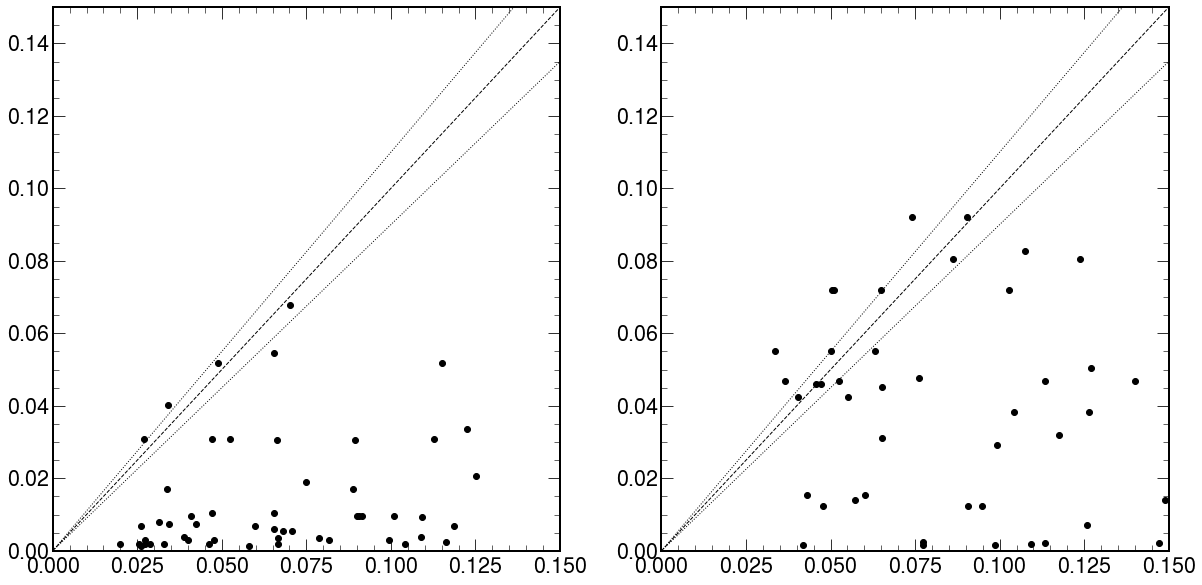

In [7]:
protons_xi_all              = np.array( np.concatenate( protons_xi_list ) )
protons_ismultirp_all       = np.array( np.concatenate( protons_ismultirp_list ) )
protons_arm_all             = np.array( np.concatenate( protons_arm_list ) )
protons_rpid1_all           = np.array( np.concatenate( protons_rpid1_list ) )
protons_rpid2_all           = np.array( np.concatenate( protons_rpid2_list ) )
protons_trackx1_all         = np.array( np.concatenate( protons_trackx1_list ) )
protons_tracky1_all         = np.array( np.concatenate( protons_tracky1_list ) )
protons_trackx2_all         = np.array( np.concatenate( protons_trackx2_list ) )
protons_tracky2_all         = np.array( np.concatenate( protons_tracky2_list ) )
protons_CrossingAngle_all   = np.array( np.concatenate( protons_CrossingAngle_list ) )
protons_InvMass_all         = np.array( np.concatenate( protons_InvMass_list ) )
protons_nExtraPfCandPV3_all = np.array( np.concatenate( protons_nExtraPfCandPV3_list ) )
protons_Acopl_all           = np.array( np.concatenate( protons_Acopl_list ) )
protons_XiMuMuPlus_all      = np.array( np.concatenate( protons_XiMuMuPlus_list ) )
protons_XiMuMuMinus_all     = np.array( np.concatenate( protons_XiMuMuMinus_list ) )
print ( len( protons_xi_all ) )
print ( protons_xi_all )
print ( protons_ismultirp_all )
print ( protons_arm_all )
print ( protons_rpid1_all )
print ( protons_rpid2_all )
print ( protons_trackx1_all )
print ( protons_tracky1_all )
print ( protons_trackx2_all )
print ( protons_tracky2_all )
print ( protons_CrossingAngle_all )
print ( protons_InvMass_all )
print ( protons_nExtraPfCandPV3_all )
print ( protons_Acopl_all )
print ( protons_XiMuMuPlus_all )
print ( protons_XiMuMuMinus_all )

msk_protons_1 = ( protons_ismultirp_all == 0 ) & ( protons_rpid1_all == 23)  
msk_protons_2 = ( protons_ismultirp_all == 0 ) & ( protons_rpid1_all == 123)  

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( protons_xi_all[ msk_protons_1 ], protons_XiMuMuPlus_all[ msk_protons_1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( protons_xi_all[ msk_protons_2 ], protons_XiMuMuMinus_all[ msk_protons_2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

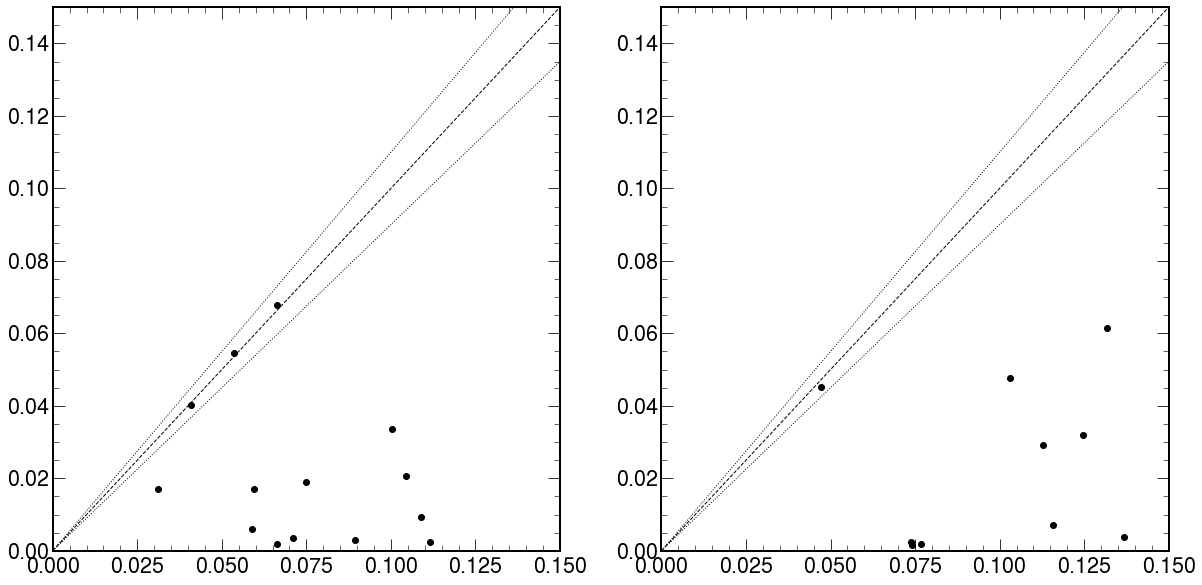

In [8]:
msk_protons_multirp_1 = ( protons_ismultirp_all == 1 ) & ( protons_arm_all == 0)
msk_protons_multirp_2 = ( protons_ismultirp_all == 1 ) & ( protons_arm_all == 1)

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( protons_xi_all[ msk_protons_multirp_1 ], protons_XiMuMuPlus_all[ msk_protons_multirp_1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( protons_xi_all[ msk_protons_multirp_2 ], protons_XiMuMuMinus_all[ msk_protons_multirp_2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

In [9]:
#fileNames = [
#    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root",
#    "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017C1.root"
#]

In [10]:
#files_with_paths = [file + ":ggll_miniaod/ntp1" for file in fileNames]
#print ( files_with_paths )
#
#keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
#        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_istight",
#        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_ndof",
#        "nPfCand", "nRecoProtCand"]
#keys.extend( uproot4.open( files_with_paths[0] ).keys( filter_name="ProtCand*" ) )
#print ( keys )
#for events_ in uproot4.iterate( files_with_paths[0], keys, library="ak", how="zip" ):
#    print ( events_ )
#    print ( len(events_) )

In [11]:
#help(uproot4.iterate)

In [12]:
#help(uproot4.TTree.iterate)

In [13]:
#help(uproot4.TTree.arrays)

In [14]:
#help(uproot4.TTree.keys)

In [15]:
data_ = np.c_[
    protons_xi_all,
    protons_ismultirp_all,
    protons_arm_all,
    protons_rpid1_all,
    protons_rpid2_all,
    protons_trackx1_all,
    protons_tracky1_all,
    protons_trackx2_all,
    protons_tracky2_all,
    protons_CrossingAngle_all,
    protons_InvMass_all,
    protons_nExtraPfCandPV3_all,
    protons_Acopl_all,
    protons_XiMuMuPlus_all,
    protons_XiMuMuMinus_all
    ]
print ( data_.shape )
columns_ = np.array( ("Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2", "XAngle", "InvMass", "ExtraPfCands", "Acopl", "XiMuMuPlus", "XiMuMuMinus"), dtype='S' )
print ( columns_ )

(157, 15)
[b'Xi' b'MultiRP' b'Arm' b'RPId1' b'RPId2' b'TrackX1' b'TrackY1'
 b'TrackX2' b'TrackY2' b'XAngle' b'InvMass' b'ExtraPfCands' b'Acopl'
 b'XiMuMuPlus' b'XiMuMuMinus']


In [16]:
with h5py.File('output-test.h5', 'w') as f:
    dset = f.create_dataset( 'protons', data=data_ )
    dset_columns = f.create_dataset( 'columns', data=columns_ )
    print ( dset )
    print ( dset[-1] )   
    print ( dset_columns )
    print ( list( dset_columns ) )      
    

<HDF5 dataset "protons": shape (157, 15), type "<f8">
[6.63192198e-02 1.00000000e+00 0.00000000e+00 3.00000000e+00
 2.30000000e+01 7.13842773e+00 7.55187988e-01 7.21130371e+00
 7.08068848e-01 1.30000000e+02 1.60619758e+02 0.00000000e+00
 1.58812270e-03 1.89449243e-03 8.05801221e-02]
<HDF5 dataset "columns": shape (15,), type "|S12">
[b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'XAngle', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlus', b'XiMuMuMinus']


In [17]:
df = None
with h5py.File('output-test.h5', 'r') as f:
#with h5py.File('output-UL2017B.h5', 'r') as f:
#with h5py.File('output/output-UL2017B-Excl.h5', 'r') as f:
#with h5py.File('output/output-UL2017B-PreSel.h5', 'r') as f:    
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    #df = pd.DataFrame( dset, columns=("Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2", "XAngle", "XiMuMuPlus", "XiMuMuMinus") )
    #df = pd.DataFrame( dset, columns=("Xi", "MultiRP", "Arm", "RPId1", "RPId2", "TrackX1", "TrackY1", "TrackX2", "TrackY2", "XAngle", "InvMass", "ExtraPfCands", "Acopl", "XiMuMuPlus", "XiMuMuMinus") )
    df = pd.DataFrame( dset, columns=columns_str )
    print ( df )


['columns', 'protons']
(157, 15)
[[ 1.23661801e-01  0.00000000e+00 -9.99000000e+02 ...  6.51268909e-03
   2.07320789e-02  4.69041116e-02]
 [ 1.25234306e-01  0.00000000e+00 -9.99000000e+02 ...  6.51268909e-03
   2.07320789e-02  4.69041116e-02]
 [ 3.65909897e-02  0.00000000e+00 -9.99000000e+02 ...  6.51268909e-03
   2.07320789e-02  4.69041116e-02]
 ...
 [ 8.63471851e-02  0.00000000e+00 -9.99000000e+02 ...  1.58812270e-03
   1.89449243e-03  8.05801221e-02]
 [ 1.23739444e-01  0.00000000e+00 -9.99000000e+02 ...  1.58812270e-03
   1.89449243e-03  8.05801221e-02]
 [ 6.63192198e-02  1.00000000e+00  0.00000000e+00 ...  1.58812270e-03
   1.89449243e-03  8.05801221e-02]]
(15,)
[b'Xi', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'XAngle', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlus', b'XiMuMuMinus']
['Xi', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2', 'XAngle', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', '

In [18]:
df

,Xi,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,TrackX2,TrackY2,XAngle,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,0.123662,0.0,-999.0,3.0,-1.0,13.371094,-0.686584,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
1,0.125234,0.0,-999.0,23.0,-1.0,13.685547,-0.869629,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
2,0.036591,0.0,-999.0,123.0,-1.0,2.308899,1.520386,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
3,0.052606,0.0,-999.0,123.0,-1.0,3.384644,2.335449,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
4,0.113379,0.0,-999.0,123.0,-1.0,7.890198,4.720215,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
5,0.140113,0.0,-999.0,123.0,-1.0,10.119385,3.386719,-999.000000,-999.000000,150.0,405.365053,1.0,0.006513,0.020732,0.046904
6,0.104382,1.0,0.0,3.0,23.0,13.371094,-0.686584,13.685547,-0.869629,150.0,405.365053,1.0,0.006513,0.020732,0.046904
7,0.069842,0.0,-999.0,3.0,-1.0,8.028809,1.144043,-999.000000,-999.000000,120.0,202.074560,0.0,0.000528,0.067829,0.003562
8,0.070282,0.0,-999.0,23.0,-1.0,8.180542,1.171875,-999.000000,-999.000000,120.0,202.074560,0.0,0.000528,0.067829,0.003562
9,0.066331,1.0,0.0,3.0,23.0,8.028809,1.144043,8.180542,1.171875,120.0,202.074560,0.0,0.000528,0.067829,0.003562


In [19]:
#( df["MultiRP"] == 0) & ( df["RPId1"] == 23 )
msk = ( df["MultiRP"] == 1) & ( df["Arm"] == 0 )
#msk = ( df["MultiRP"] == 1) & ( df["Arm"] == 1 )
df[ msk ]

,Xi,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,TrackX2,TrackY2,XAngle,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
6,0.104382,1.0,0.0,3.0,23.0,13.371094,-0.686584,13.685547,-0.869629,150.0,405.365053,1.0,0.006513,0.020732,0.046904
9,0.066331,1.0,0.0,3.0,23.0,8.028809,1.144043,8.180542,1.171875,120.0,202.074560,0.0,0.000528,0.067829,0.003562
14,0.111563,1.0,0.0,3.0,23.0,12.952148,2.877441,13.117676,2.904053,140.0,199.256934,1.0,0.000427,0.002549,0.092167
27,0.074831,1.0,0.0,3.0,23.0,7.796631,1.404907,7.863098,1.423584,140.0,221.979700,0.0,0.000296,0.019086,0.015278
42,0.031182,1.0,0.0,3.0,23.0,3.370483,0.473846,3.474884,0.539917,130.0,151.635859,0.0,0.004018,0.017178,0.007925
45,0.053652,1.0,0.0,3.0,23.0,6.514648,1.121338,6.754150,1.131470,140.0,252.650875,0.0,0.000026,0.054611,0.006917
50,0.040781,1.0,0.0,3.0,23.0,3.294312,0.699707,3.185455,0.784241,150.0,116.450784,0.0,0.001532,0.040098,0.002001
54,0.100377,1.0,0.0,3.0,23.0,13.586426,3.961182,13.945435,4.120117,140.0,120.564655,1.0,0.006412,0.033731,0.002550
100,0.108825,1.0,0.0,3.0,23.0,12.577637,3.110840,12.712036,3.217773,130.0,213.642190,0.0,0.000262,0.009318,0.028985
125,0.059035,1.0,0.0,3.0,23.0,6.600586,1.398315,6.746155,1.446777,140.0,131.453919,0.0,0.003870,0.006079,0.016821


(0.0, 0.15)

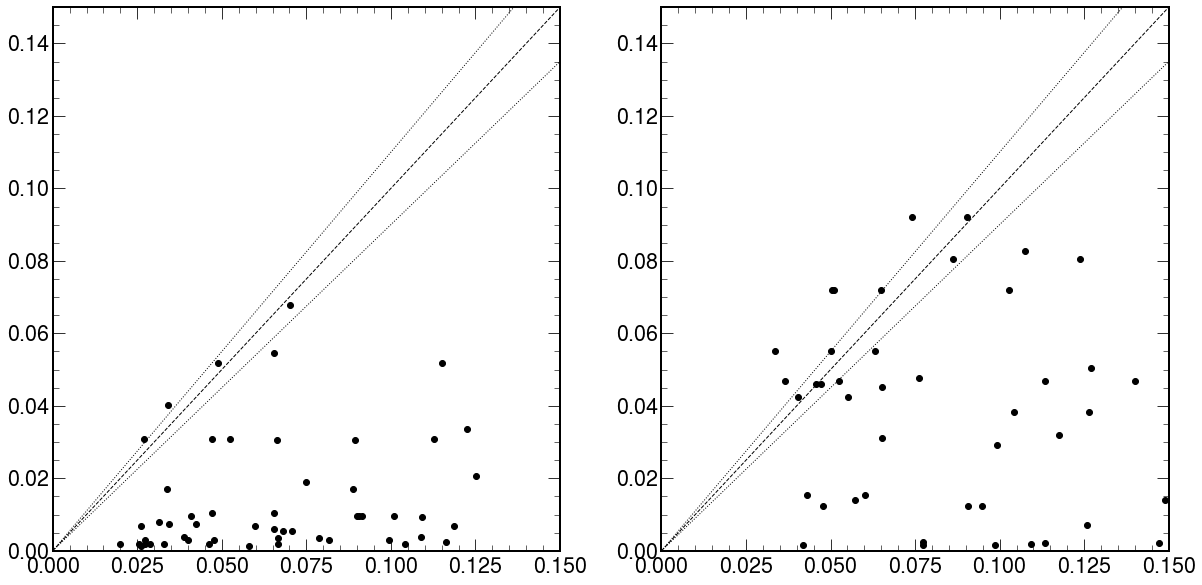

In [20]:
msk1 = ( df["MultiRP"] == 0) & ( df["RPId1"] == 23 )
msk2 = ( df["MultiRP"] == 0) & ( df["RPId1"] == 123 )
#msk1 = ( df["MultiRP"] == 1) & ( df["Arm"] == 0 )
#msk2 = ( df["MultiRP"] == 1) & ( df["Arm"] == 1 )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].plot( df[ "Xi" ][ msk1 ], df[ "XiMuMuPlus" ][ msk1 ], 'ko' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df[ "Xi" ][ msk2 ], df[ "XiMuMuMinus" ][ msk2 ], 'ko' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)